# SEOUL Bike Sharing Demand

>The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information

In this notebook, we'll do regression to predict number of bicycles rented. Do note that the trained models are not particularly great, the notebook is just for showcasing how to train a linear regression model, and how to train similar model using Neural Net.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import copy
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Read Data

In [37]:
# path_to_file = "/kaggle/input/seoul-bike-data/SeoulBikeData.csv"
path_to_file = "SeoulBikeData.csv"
df = pd.read_csv(path_to_file)

In [38]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


Let's drop some columns that we're not going to use

In [39]:
df = df.drop(["Date", "Seasons", "Holiday"], axis=1)

Let's rename the columns

In [40]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df.columns = dataset_cols
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bike_count   8760 non-null   int64  
 1   hour         8760 non-null   int64  
 2   temp         8760 non-null   float64
 3   humidity     8760 non-null   int64  
 4   wind         8760 non-null   float64
 5   visibility   8760 non-null   int64  
 6   dew_pt_temp  8760 non-null   float64
 7   radiation    8760 non-null   float64
 8   rain         8760 non-null   float64
 9   snow         8760 non-null   float64
 10  functional   8760 non-null   object 
dtypes: float64(6), int64(4), object(1)
memory usage: 752.9+ KB


In [42]:
df.describe()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


Convert functional to either 0 or 1

In [43]:
df["functional"] = (df["functional"] == "Yes").astype(int)

Let's work on the data at noon for now

In [44]:
df = df[df["hour"] == 12]
df = df.drop("hour", axis=1)

In [45]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


Let's see how each feature affects `bike_count`

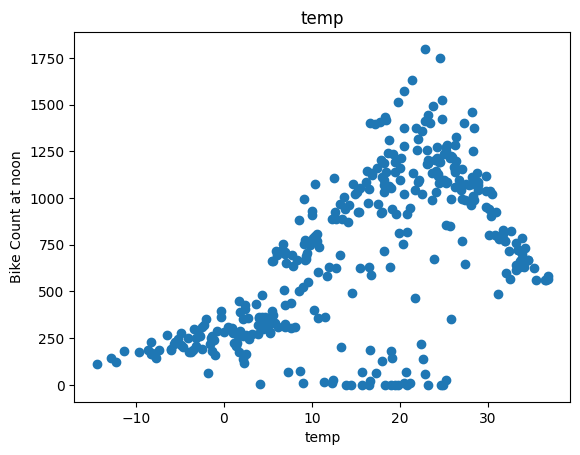

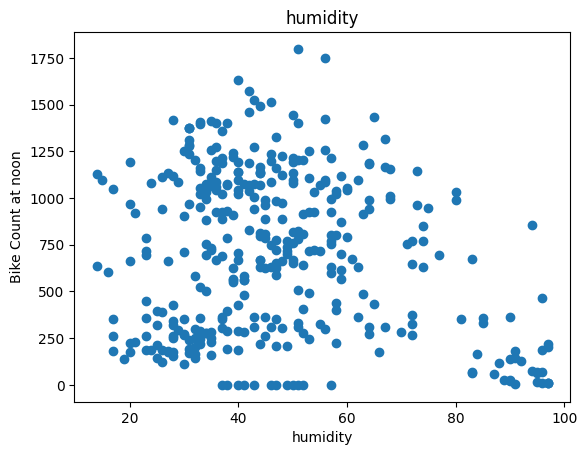

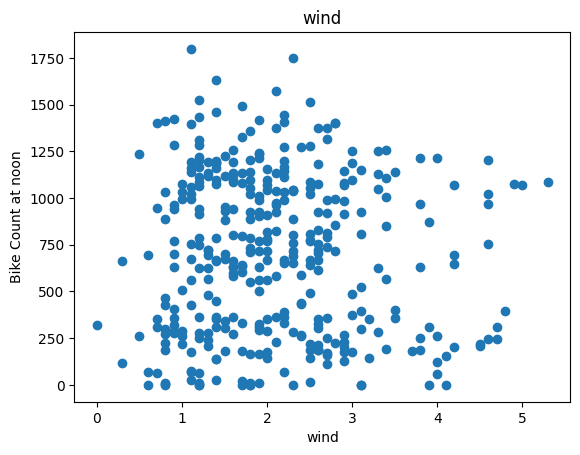

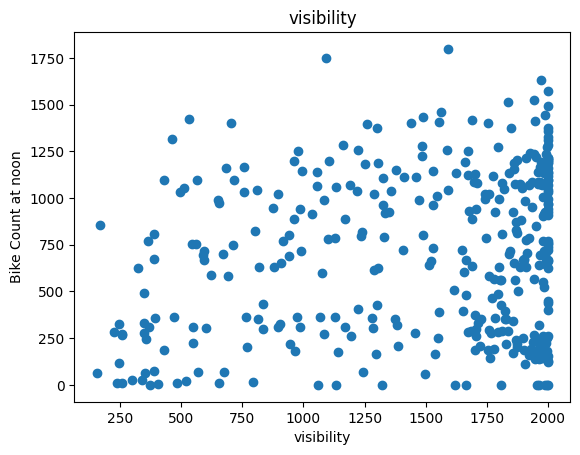

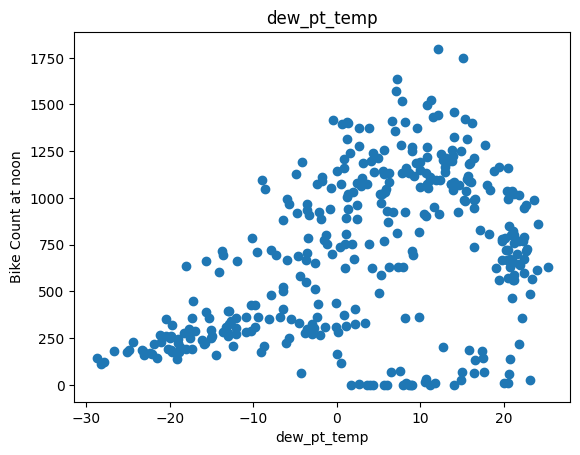

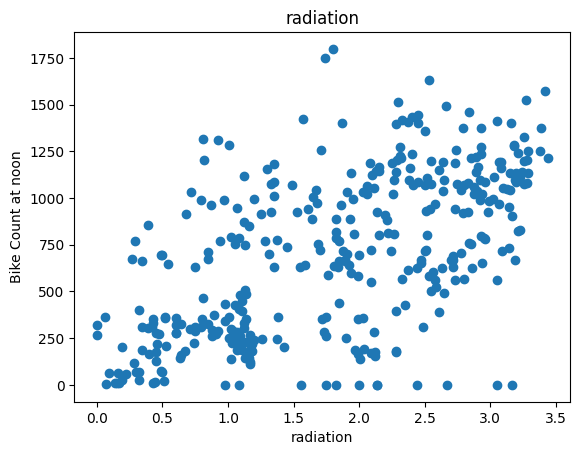

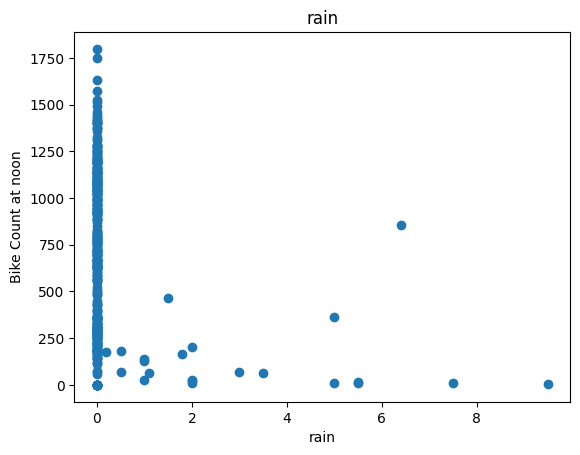

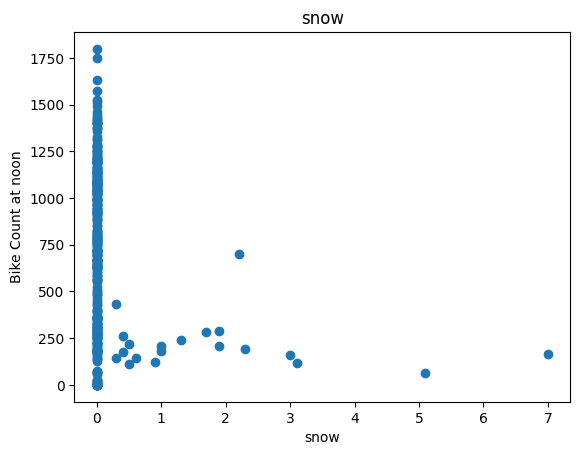

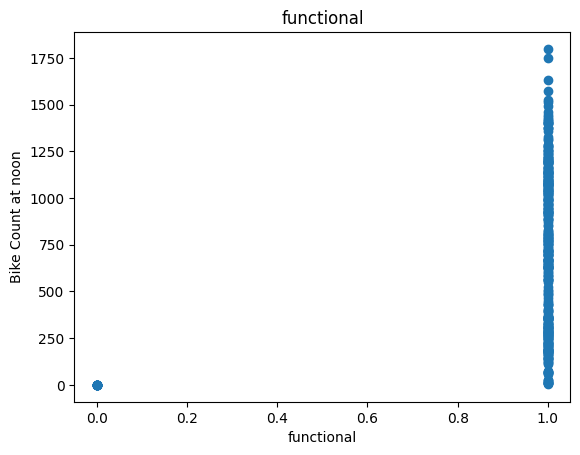

In [46]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.ylabel("Bike Count at noon")
    plt.xlabel(label)
    plt.show()

Seems like some features are not telling much, so let's drop them

In [47]:
df = df.drop(["wind", "visibility", "functional"], axis=1)

## Helper

In [48]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        # All columns except y_label
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1) # because it's 1D
        else:
            X = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1, 1)

    data = np.hstack((X, y))

    return data, X, y

## Linear Regression With 1 Variable



In [52]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [53]:
len(train), len(valid), len(test)

(219, 73, 73)

As we can see in the plot above, seems like `temp` is most useful for predicting `bike_count`. So we're going to train a linear regression model on that feature.

In [54]:
_, X_train, y_train = get_xy(train, "bike_count", x_labels=["temp"])
_, X_valid, y_valid = get_xy(valid, "bike_count", x_labels=["temp"])
_, X_test, y_test = get_xy(test, "bike_count", x_labels=["temp"])

In [55]:
temp_regressor = LinearRegression()
temp_regressor.fit(X_train, y_train)

LinearRegression()

In [56]:
temp_regressor.coef_, temp_regressor.intercept_ # check the trained w and b

(array([[20.04595673]]), array([413.93970248]))

In [57]:
temp_regressor.score(X_test, y_test) # check R^2 score

0.26171758383590216

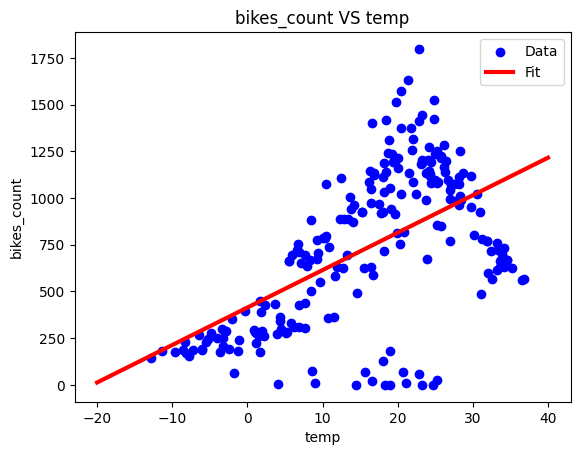

In [68]:
plt.scatter(X_train, y_train, label="Data", color="blue")
x = np.linspace(-20, 40, 100)
plt.plot(x, temp_regressor.predict(x.reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("bikes_count VS temp")
plt.ylabel("bikes_count")
plt.xlabel("temp")
plt.show()

## Linear Regression With Multiple Variables

In [73]:
train, test = np.split(df.sample(frac=1), [int(0.8*len(df))])

In [74]:
_, X_train, y_train = get_xy(train, "bike_count")
_, X_test, y_test = get_xy(test, "bike_count")

In [75]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [76]:
regressor.coef_, regressor.intercept_, regressor.score(X_test, y_test)

(array([[ -4.48738973,  -9.26330248,  23.11757943, 133.98884397,
         -21.54871794, -19.77312454]]),
 array([892.92588156]),
 0.46374596280670455)

The score improved!

## Regression With Neural Network

Let's do it on 1 single feature (temperature) just like above and see how it compares!

In [92]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train, y_train = get_xy(train, "bike_count", x_labels=["temp"])
_, X_valid, y_valid = get_xy(valid, "bike_count", x_labels=["temp"])
_, X_test, y_test = get_xy(test, "bike_count", x_labels=["temp"])

In [82]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [93]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train.reshape(-1))

In [94]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1) # 1 single node means it's linear
])

In [95]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [96]:
history = temp_nn_model.fit(
    X_train.reshape(-1), y_train,
    verbose=0,
    epochs=1000,
    validation_data=(X_valid, y_valid)
)

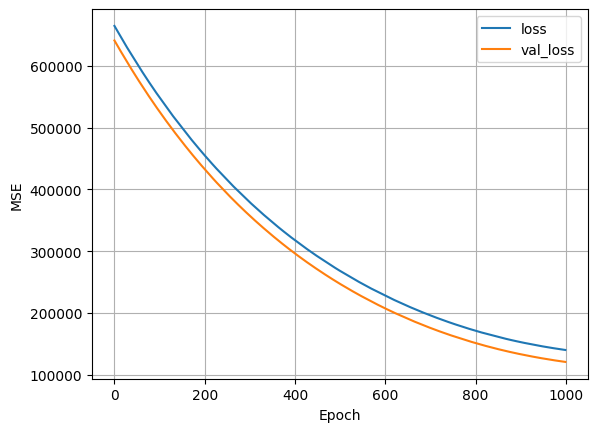

In [97]:
plot_loss(history) # see how it's slowly converging

4/4 [==============================] - 0s 2ms/step


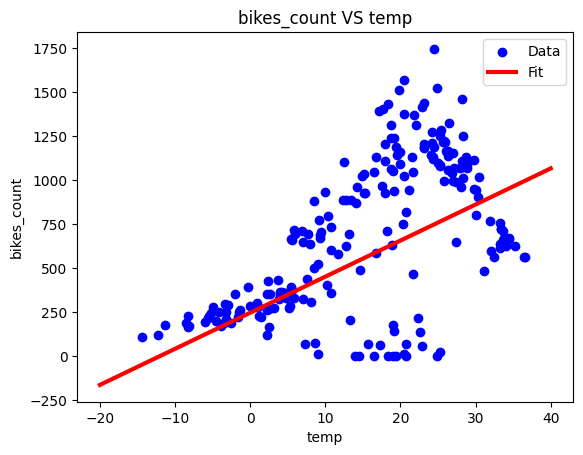

In [98]:
plt.scatter(X_train, y_train, label="Data", color="blue")
x = np.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(x.reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("bikes_count VS temp")
plt.ylabel("bikes_count")
plt.xlabel("temp")
plt.show()

## Neural Net

In [99]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [100]:
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    verbose=0, epochs=100
)

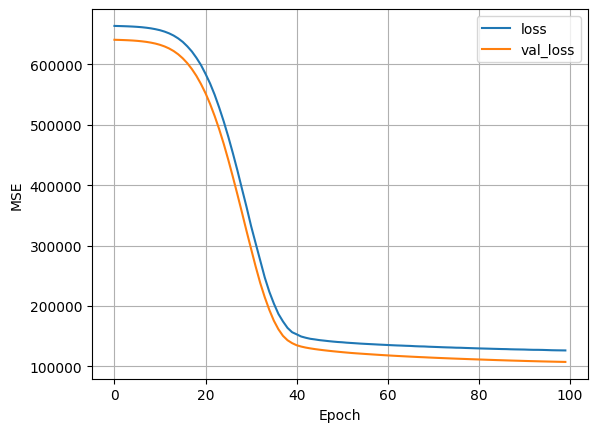

In [101]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


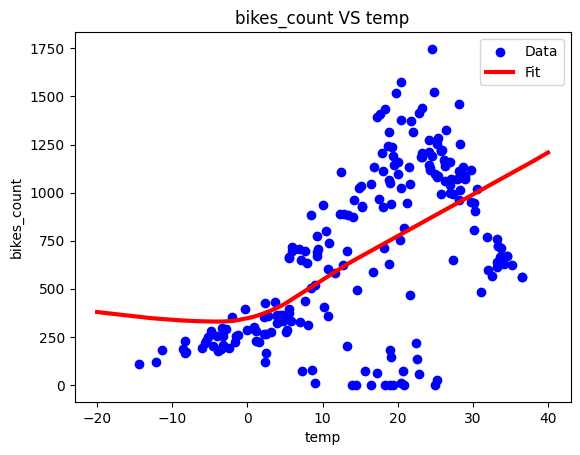

In [102]:
plt.scatter(X_train, y_train, label="Data", color="blue")
x = np.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(x.reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("bikes_count VS temp")
plt.ylabel("bikes_count")
plt.xlabel("temp")
plt.show()

## With multiple features

In [103]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train, y_train = get_xy(train, "bike_count")
_, X_valid, y_valid = get_xy(valid, "bike_count")
_, X_test, y_test = get_xy(test, "bike_count")

In [105]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train)

In [106]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [109]:
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    verbose=0, epochs=100
)

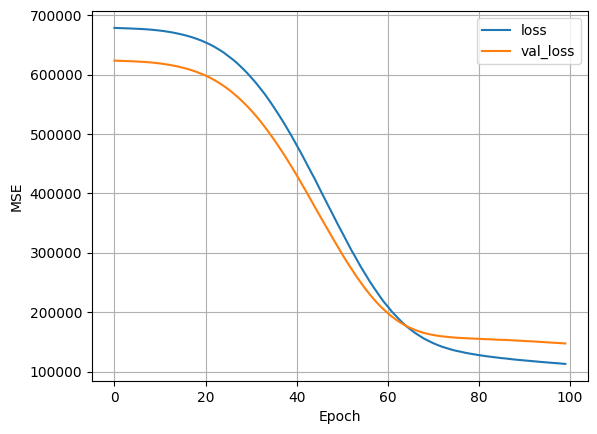

In [110]:
plot_loss(history)

In [112]:
# calculate the MSE for both linear reg and nn
y_pred_lr = regressor.predict(X_test)
y_pred_nn = nn_model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


In [113]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [114]:
MSE(y_pred_lr, y_test)

96021.87124964797

In [115]:
MSE(y_pred_nn, y_test)

121637.97818593602

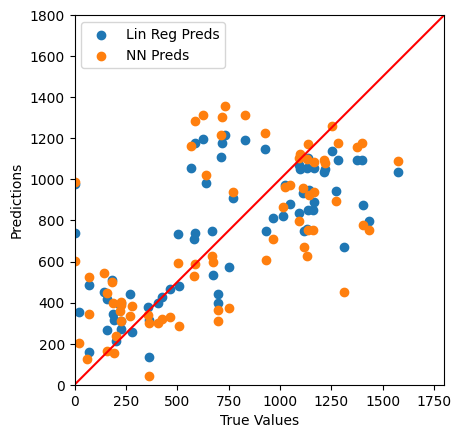

In [116]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")